In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import numpy as np
from arnie.pfunc import pfunc
from arnie.bpps import bpps
from arnie.sample_structures import sample_structures
import arnie.utils as utils
from decimal import Decimal
from arnie.free_energy import free_energy

import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
mpl.rcParams['figure.dpi']= 300


Populating the interactive namespace from numpy and matplotlib


In [82]:
hhr = "ACGCUGUCUGUACUUGUAUCAGUACACUGACGAGUCCCUAAAGGACGAAACAGCGC"
n_samples=10000

struct_list, _ , _ = sample_structures(hhr, n_samples=n_samples, package='vienna_2')

vienna_energy_list = [free_energy(hhr, structure=s.replace('.','x'), package='vienna_2')[0] for s in struct_list]
# Not used in the reweighting, but including them here to compare to the contrafold energies

contrafold_energy_list = [free_energy(hhr, structure=s.replace('.','x'), package='contrafold')[0] for s in struct_list]

In [83]:
vienna_energy_list -= np.max(vienna_energy_list)
contrafold_energy_list -= np.max(contrafold_energy_list)
# vienna_energy_list /= np.min(vienna_energy_list)
# contrafold_energy_list /= np.min(contrafold_energy_list)

In [84]:
#to save:

with open('hhr_struct_list.txt','w') as f:
    for i in range(n_samples):
        f.write("%s\t%.d%.d\n" % (struct_list[i],vienna_energy_list[i],contrafold_energy_list[i]))

Our coordinates in consideration are the posterior probabilities of possible base pair, p_ij. We histogram these from our sampled reference system (Vienna) to get $p_{old}$. Then for each base, we weight by the scaled Boltzmann factor as estimated with Contrafold.

$p_{new}(i:j) = p_{old}(i:j) \dfrac{\langle \exp (\beta dG)\rangle_j}{\sum \langle \exp (\beta dG)\rangle_j}$

In [94]:
count_unpaired = {'.':1, '(':0, ')':0}

beta=1/0.6
boltzmann_weights=[]

sampled_posterior=np.mean([utils.convert_dotbracket_to_matrix(s) for s in struct_list],axis=0)

norm_factor = np.mean(np.exp(beta*(np.array(contrafold_energy_list)-np.array(vienna_energy_list))))
boltzmann_weights = [np.exp(beta*(ddG))/norm_factor for ddG in np.subtract(contrafold_energy_list,vienna_energy_list)] #/norm_factor

reweighted_posterior = np.zeros([len(hhr),len(hhr)])

for i in range(n_samples):
    reweighted_posterior += utils.convert_dotbracket_to_matrix(struct_list[i])*boltzmann_weights[i]

reweighted_posterior = reweighted_posterior/n_samples

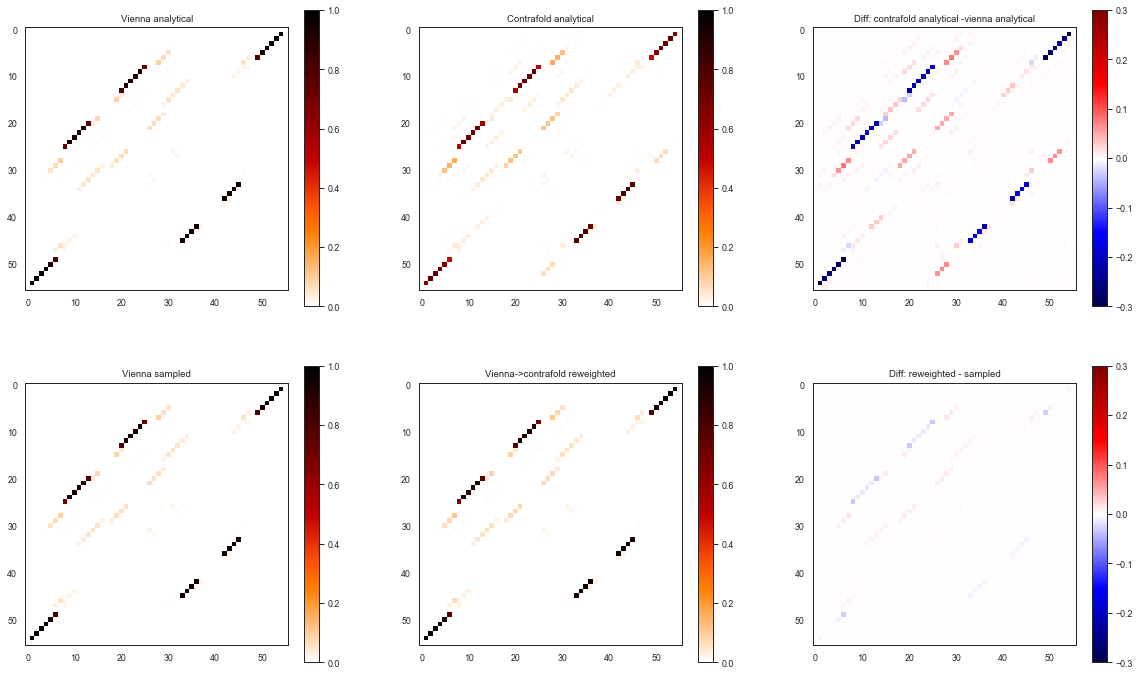

In [102]:
figure(figsize=(20,12))
subplot(2,3,1)
title('Vienna analytical')
imshow(bpps(hhr,package='vienna_2'),cmap='gist_heat_r',vmin=0,vmax=1)
colorbar()

subplot(2,3,2)
title('Contrafold analytical')
imshow(bpps(hhr,package='contrafold'),cmap='gist_heat_r',vmin=0,vmax=1)
colorbar()

subplot(2,3,3)
title('Diff: contrafold analytical -vienna analytical')
imshow(bpps(hhr,package='contrafold')-bpps(hhr,package='vienna_2'),cmap='seismic',vmin=-0.3,vmax=0.3)
colorbar()

subplot(2,3,4)
title('Vienna sampled')
imshow(sampled_posterior,cmap='gist_heat_r',vmin=0,vmax=1)
colorbar()
subplot(2,3,5)
title('Vienna->contrafold reweighted')
imshow(reweighted_posterior,cmap='gist_heat_r',vmin=0,vmax=1)
colorbar()
subplot(2,3,6)
title('Diff: reweighted - sampled')
imshow(reweighted_posterior - sampled_posterior, cmap='seismic',vmin=-0.3,vmax=0.3)
colorbar()
savefig('hhr_reweighting.pdf',bbox_inches='tight',dpi=300)

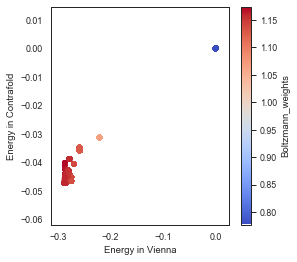

In [93]:
figure(figsize=(4,4))
scatter(vienna_energy_list,contrafold_energy_list, c=boltzmann_weights, cmap='coolwarm')
xlabel('Energy in Vienna')
ylabel('Energy in Contrafold')
colorbar(label='Boltzmann_weights')

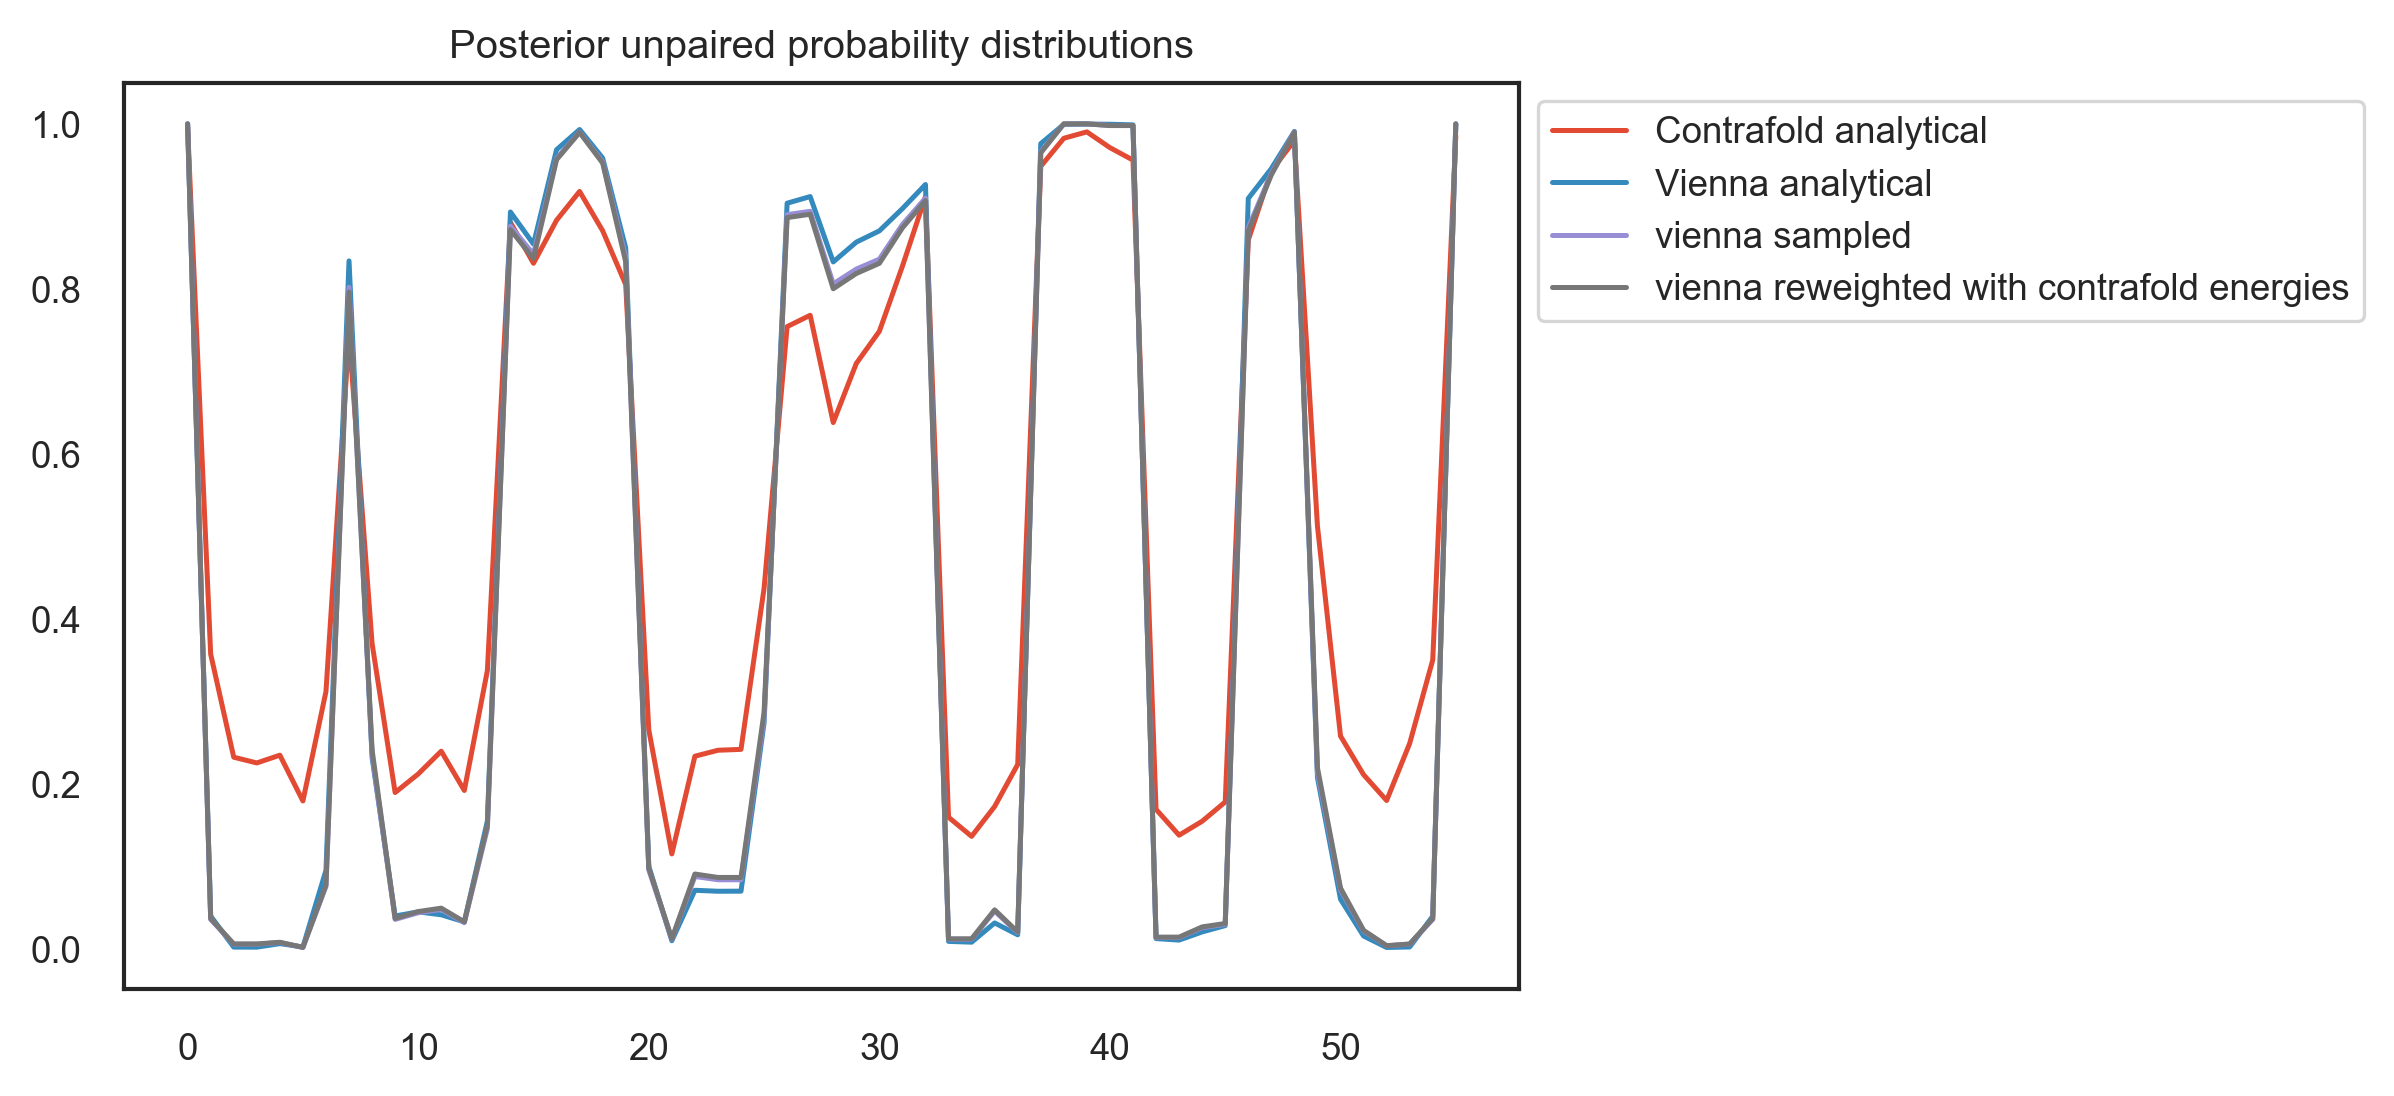

In [152]:
from arnie.bpps import bpps

cfold_bp_matrix = bpps(hhr,package='contrafold')
vienna_bp_matrix = bpps(hhr,package='vienna_2')

title('Posterior unpaired probability distributions')
plot(1-np.sum(cfold_bp_matrix,axis=0),label='Contrafold analytical')
plot(1-np.sum(vienna_bp_matrix,axis=0),label='Vienna analytical')

plot(ref_paired_distn/n_samples,label='vienna sampled')
plot(reweighted_paired_distn/n_samples,label='vienna reweighted with contrafold energies')

legend(bbox_to_anchor=(1,1))